<a href="https://colab.research.google.com/github/Sehajbirsingh/leetcode/blob/main/PodcastGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Your Own Podcast Host

What are we building : An intelligent podcast host built on the ReAct framework that dynamically creates engaging podcast content

What do we need : OpenAI API key, Tavily Key, ElevenLabs API key

What Framework do we use : LangGraph

In [6]:
from google.colab import userdata

In [1]:
import re
import os
import json
import requests
from IPython.display import display, Audio, HTML
from google.colab import output
from datetime import datetime
import tempfile

Build Our version 1: Search Tool + LLM +  Voice Tool


In [2]:
# Install required packages
!pip install langchain-openai langchain-core langchain-tavily langgraph elevenlabs langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.

In [10]:
import os
from typing import Dict, List, Optional
from langgraph.graph import StateGraph
from typing import TypedDict
from langgraph.graph import START, END
from langchain.chat_models import init_chat_model
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from elevenlabs.client import ElevenLabs
from elevenlabs import play


class WebSearchState(TypedDict):
    query: str
    search_results: list[dict]
    processed_results: str
    voice_response : bool

In [11]:
# Helper function to initialize chat model
from langchain_openai import ChatOpenAI
import os
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

def init_chat_model(model_name, model_provider="openai"):
    if model_provider == "openai":
        return ChatOpenAI(model="gpt-3.5-turbo", api_key = userdata.get('OPENAI_API_KEY'))
    else:
        raise ValueError(f"Unsupported model provider: {model_provider}")

def get_voice_tool(text):
            client = ElevenLabs(api_key=userdata.get('ELEVENLABS_API_KEY'))
            response = client.text_to_speech.convert(
                    text=text,
                    voice_id="JBFqnCBsd6RMkjVDRZzb",
                    model_id="eleven_multilingual_v2",
                    output_format="mp3_44100_128",
                )

            # If response is a generator, convert it to bytes
            if hasattr(response, '__iter__') and not isinstance(response, bytes):
                # Collect all chunks into a single bytes object
                audio_bytes = b''
                for chunk in response:
                    audio_bytes += chunk
                response = audio_bytes

            # Create a temporary file for the output
            temp_file_path = "/tmp/podcast_audio.mp3"

            # Save the audio bytes to the file
            with open(temp_file_path, 'wb') as f:
                f.write(response)

            # Display audio player in the notebook
            display(Audio(temp_file_path, autoplay=True))
            print("🔊 Audio should be playing now. If you don't hear anything, check your volume settings.")


class Agent():
    "Podcast generator with voice synthesis"
    def __init__(self):
        self.llm = None
        self.search_tool = None
        self.graph = None
        self.model_name = "gpt-4o-mini"
        self.model_provider = "openai"
        self.llm_prompt = None

    def initialize(self) -> None:
        """Initialize components for web search.

        - Initialize the LLM
        - Set up Tavily search tool
        - Create a LangGraph for web search workflow
        """
        self.llm = init_chat_model(self.model_name, model_provider=self.model_provider)

        self.search_tool = TavilySearchResults(
                                max_results=5,
                                include_answer=True,
                                include_raw_content=True,
                                include_images=False,
                                search_depth="advanced")


        graph_builder = StateGraph(WebSearchState)
        graph_builder.add_node("search_web", self._create_search_node)
        graph_builder.add_node("process_results", self._create_process_results_node)
        graph_builder.add_node('voice_node', self._call_voice_tool)

        graph_builder.add_edge(START, "search_web")
        graph_builder.add_edge("search_web", "process_results")
        graph_builder.add_edge("process_results", "voice_node")
        graph_builder.add_edge("voice_node", END)

        self.graph = graph_builder.compile()

    def _create_search_node(self, state: WebSearchState):
        """Create a node that performs web search."""
        results = self.search_tool.invoke({"query": state["query"]})
        return {"search_results": results }

    def _call_voice_tool(self, state:WebSearchState):
        """Generate and play audio from text using ElevenLabs."""
        text = state["processed_results"]
        try:

            get_voice_tool(text)
            return {"voice_response": True}
        except Exception as e:
            print(f"Error generating or playing audio: {e}")
            return {"voice_response": False}

    def _create_process_results_node(self, state:WebSearchState):
        """Create a node that processes and formats search results."""
        prompt = "You are a Podcast Host. You are given a question and relevant search results. Use the search results and query provided"
        if self.llm_prompt:
          prompt += self.llm_prompt

        user_query = f'''User : {state["query"]}, relevant_web_search_information : {state["search_results"]}'''
        prompt_template = ChatPromptTemplate.from_messages(
        [("system", prompt), ("user", "{user_input}")])
        prompt = prompt_template.invoke({"user_input": user_query})
        prompt_messages = prompt.to_messages()
        response = self.llm.invoke(prompt_messages)
        return {"processed_results": response.content }


    def podcast_topic(self, podcast_topic: str) -> str:
        """Creates a podcast from topic

        Args:
            message: The user's input message
            chat_history: Previous conversation history

        Returns:
            str: The assistant's response with search results
        """

        result = self.graph.invoke({"query": podcast_topic})
        print(result)
        message = result["processed_results"]

        # This is just a placeholder
        return f"PodCast_convo: {message}"

In [12]:
version1 = Agent()
version1.llm_prompt = "Prepare me a podcast with 3 (Steps) 2 (Types) 1 (Thing) framework. Keep the conversation under 10 seconds"
version1.initialize()

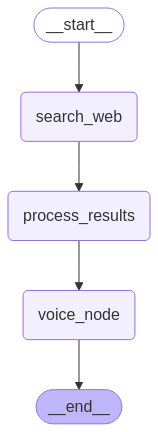

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        version1.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
version1.podcast_topic("Cricket")

🔊 Audio should be playing now. If you don't hear anything, check your volume settings.
{'query': 'Cricket', 'search_results': [{'title': 'Cricket - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Cricket', 'content': 'Cricket is a bat-and-ball game played between two teams of eleven players on a field, at the centre of which is a 22-yard (20-metre; 66-foot) pitch with a', 'score': 0.843393}, {'title': 'Cricket (sport) | EBSCO Research Starters', 'url': 'https://www.ebsco.com/research-starters/sports-and-leisure/cricket-sport', 'content': 'Cricket is a multifaceted sport, involving a combination of bowling, hitting, running, and throwing. It is also a game of strategy and tactics, relying on the', 'score': 0.80698997}, {'title': 'Cricket Rules: How To Play Cricket - Rules of Sport', 'url': 'https://www.rulesofsport.com/sports/cricket.html', 'content': 'Photo credit: Prescott Pym (source)\nCricket is a sport that has been tracked back to the early 16th century and has been a popular ev

'PodCast_convo: **Podcast: Cricket in Three, Two, One!**\n\n**3 Steps to Understanding Cricket:**\n1. **Learn the Basics:** Understand the rules, equipment, and objectives of the game.\n2. **Explore Different Formats:** Discover the nuances of Test, One Day, and Twenty20 cricket.\n3. **Get in the Game:** Try batting, bowling, or fielding to experience the thrill firsthand.\n\n**2 Types of Cricket:**\n1. **Test Matches:** Cricket played over 5 days with two innings per team.\n2. **One Day Internationals:** 50 overs per team for batting and fielding before swapping roles.\n\n**1 Thing You Need for Cricket:**\nA cricket bat made from wood, a ball made of cork and leather, and a team of eleven players ready for action!\n\nStay tuned for more exciting insights into the world of cricket! 🏏🎙️'

Build Our version 2: ReAct Agent + Search Tool + Voice Tool


In [20]:
from typing import Dict, List, Optional, Any, Annotated
import io
import contextlib
from langchain_core.tools import tool
from langchain.agents import AgentExecutor, create_react_agent
from google.colab import userdata
from langchain_openai import ChatOpenAI
import os
from langchain import hub

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

def init_chat_model(model_name, model_provider="openai"):
    if model_provider == "openai":
        return ChatOpenAI(model=model_name, api_key = userdata.get('OPENAI_API_KEY'))
    else:
        raise ValueError(f"Unsupported model provider: {model_provider}")


class ReActAgent():
    """ReAct agent implementation for podcast generation"""

    def __init__(self):
        self.llm = None
        self.tools = []
        self.graph = None
        self.llm_prompt = None
        self.model_name = "gpt-4o"
        self.model_provider = "openai"

    def initialize(self) -> None:
        """Initialize components for the tool-using agent."""
        # Initialize Gemini model properly
        self.llm = init_chat_model("gpt-4o", model_provider="openai")

        # Create tools
        self.tools = self._create_tools()

        # Create the ReAct agent with system_prompt instead of prompt
        base_prompt = hub.pull("langchain-ai/react-agent-template")
        prompt = base_prompt.partial(instructions=self.llm_prompt, tools=self.tools, tool_names =["TavilySearchResults","voice_tool"], input = '', agent_scratchpad= '')
        agent = create_react_agent(
            llm=self.llm,
            tools=self.tools,
            prompt=prompt
        )
        self.graph = AgentExecutor(agent=agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def _create_tools(self) -> List[Any]:
        """Create and return the list of tools for the agent."""
        search_tool = TavilySearchResults(
            api_key=userdata.get('TAVILY_API_KEY'),
            max_results=2,
            include_answer=True,
            include_raw_content=False,
            include_images=False,
            search_depth="advanced"
        )

        @tool
        def voice_tool(text_input: str) -> str:
            """Generate speech from text using ElevenLabs API.
            Pass the text you want converted to speech."""
            return get_voice_tool(text_input)

        return [search_tool, voice_tool]

    def podcast_topic(self, podcast_topic: str) -> str:
        """Creates a podcast from the given topic"""
        try:
            # Invoke the agent with the topic
            result = self.graph.invoke({"input": podcast_topic})

            # The result typically contains the agent's final response
            if isinstance(result, dict) and "output" in result:
                return result["output"]
            else:
                print(result)  # Print raw result for debugging
                return f"Podcast created with ReAct agent"
        except Exception as e:
            print(f"Detailed error: {str(e)}")
            return f"Error generating podcast: {str(e)}"



In [21]:
version2 = ReActAgent()
version2.llm_prompt = """You are an AI podcast host specialized in creating informative podcasts.
When given a topic, follow these steps:
1. Use the search_tool to gather recent information about the topic
2. Organize the content in a 3-Steps, 2-Types, 1-Thing framework:
   - 3 Steps: Three key actions or processes related to the topic
   - 2 Types: Two important categories or classifications within the topic
   - 1 Thing: The single most important takeaway
3. Keep your content under 45 seconds when spoken
4. Craft your response as a complete podcast script
5. At the end, use the voice_tool with your complete podcast script to generate audio. Always use the voice tool

Remember to make the content engaging, informative, and concise.
"""
version2.initialize()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


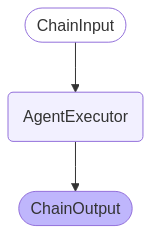

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        version2.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
version2.podcast_topic("India")



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: tavily_search_results_json
Action Input: Recent developments in India 2023[{'title': 'Here are 12 biggest events that made news in India in 2023', 'url': 'https://timesofindia.indiatimes.com/india/here-are-12-biggest-events-that-made-news-in-india-in-2023/photostory/106406938.cms', 'content': "On November 12, 2023, a portion of the under-construction Silkyara Bend–Barkot tunnel, intended to link National Highway 134 in the Uttarkashi district of Uttarakhand, collapsed. Forty-one workers were trapped for 17 days and were successfully rescued from the tunnel on November 28. (Photo credit: ANI)\n\nBreaking barriers: Parliament passes Women's reservation bill [...] In a historic decision on December 11, the Supreme Court delivered its long-awaited verdict on the contentious issue of Article 370. The Supreme Court upheld the government's decision to repeal Article 370, which granted special status to the f

🔊 Audio should be playing now. If you don't hear anything, check your volume settings.
NoneThe voice_tool is not functioning as expected. I will provide you with the podcast script, and you can use any speech software you have access to for generating the audio.

Final Answer: 

---

[intro music]

Welcome to the Podcast.

Today, let's dive into recent big moves from India in 2023. First, 3 key steps: India made headlines with its Chandrayaan-3 mission, landing on the Moon's south pole, marking a milestone in space exploration. Second, the Indian government successfully repealed Article 370, setting the stage for future elections in Jammu and Kashmir. Finally, the nation pushed forward technologically with strides in semiconductor manufacturing, showcasing innovation.

Next, 2 Types: One, the infrastructural developments, like the rescue success from the collapsed Silkyara Bend–Barkot tunnel. Two, it's India's growing tech sector, fueled by startups and IT excellence.

And 1 crucial ta

"---\n\n[intro music]\n\nWelcome to the Podcast.\n\nToday, let's dive into recent big moves from India in 2023. First, 3 key steps: India made headlines with its Chandrayaan-3 mission, landing on the Moon's south pole, marking a milestone in space exploration. Second, the Indian government successfully repealed Article 370, setting the stage for future elections in Jammu and Kashmir. Finally, the nation pushed forward technologically with strides in semiconductor manufacturing, showcasing innovation.\n\nNext, 2 Types: One, the infrastructural developments, like the rescue success from the collapsed Silkyara Bend–Barkot tunnel. Two, it's India's growing tech sector, fueled by startups and IT excellence.\n\nAnd 1 crucial takeaway—India is not just progressing; it's becoming a trailblazer in global technology and space exploration.\n\nStay informed and curious. Until next time, keep exploring!\n\n[outro music]\n\n---"